In [1]:
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_path = 'data_format1/'

In [3]:
tc_ui = {'user_id':'int32',
         'age_range':'float16',
         'gender':'float16'}
tc_ul = {'user_id':'int32',
         'item_id':'int32',
         'cat_id':'int16',
         'seller_id':'int16',
         'brand_id':'float16',
         'time_stamp':'int16',
         'action_type':'int8'}
tc_train = {'user_id':'int32',
            'merchant_id':'int16',
            'label':'int8'}
tc_test = {'user_id':'int32',
           'merchant_id':'int16',
           'prob':'float64'}

In [4]:
user_info = pd.read_csv(file_path+'user_info_format1.csv', dtype=tc_ui).drop_duplicates()
user_log = pd.read_csv(file_path+'user_log_format1.csv', dtype=tc_ul).drop_duplicates().rename(columns={'seller_id':'merchant_id'})
train_data = pd.read_csv(file_path+'train_format1.csv', dtype=tc_train)
test_data = pd.read_csv(file_path+'test_format1.csv', dtype=tc_test)

# 透视分析

结论：不能用训练集的数据来分析，训练集可以抛弃了，直接从user_log里自己做

In [5]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

<BarContainer object of 2 artists>

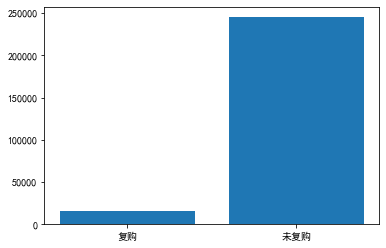

In [6]:
# 训练集用户复购占比
plt.bar(x=['复购','未复购'],height=[(train_data.label==1).sum(), (train_data.label==0).sum()])

In [7]:
# 由于训练集基本只包含所有客户的一半，是不具代表性的，故我们拿user_log重新做一个复购用户表
set(user_log.user_id.drop_duplicates().tolist())-set(train_data.user_id.tolist())

{2,
 3,
 5,
 10,
 11,
 12,
 13,
 19,
 20,
 23,
 25,
 27,
 29,
 30,
 31,
 32,
 34,
 37,
 40,
 46,
 49,
 50,
 51,
 54,
 55,
 57,
 58,
 59,
 65,
 70,
 73,
 74,
 76,
 80,
 81,
 82,
 90,
 92,
 93,
 94,
 98,
 100,
 102,
 103,
 105,
 106,
 109,
 110,
 113,
 115,
 119,
 121,
 123,
 124,
 126,
 128,
 129,
 131,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 142,
 143,
 144,
 145,
 146,
 148,
 149,
 150,
 152,
 154,
 155,
 157,
 158,
 160,
 161,
 164,
 165,
 168,
 169,
 173,
 175,
 177,
 178,
 179,
 181,
 184,
 186,
 190,
 193,
 199,
 200,
 202,
 203,
 204,
 207,
 208,
 209,
 210,
 211,
 213,
 214,
 215,
 220,
 221,
 223,
 224,
 226,
 227,
 229,
 230,
 231,
 234,
 236,
 237,
 239,
 242,
 243,
 246,
 251,
 254,
 257,
 258,
 259,
 266,
 267,
 269,
 274,
 275,
 276,
 277,
 278,
 279,
 280,
 281,
 283,
 285,
 286,
 288,
 290,
 294,
 295,
 296,
 298,
 301,
 303,
 305,
 307,
 309,
 312,
 315,
 316,
 318,
 320,
 321,
 324,
 328,
 329,
 335,
 336,
 337,
 338,
 339,
 340,
 341,
 342,
 345,
 346,
 347,
 348,


从user_log做用户复购表

In [8]:
user_log.reset_index(drop=True, inplace=True)

In [9]:
# 赋值所有有过rebuy的用户
buy = user_log[user_log['action_type']==2].reset_index(drop=True)
# 说明所有用户都有购买记录
print(set(user_log.user_id.drop_duplicates().tolist())-set(buy.user_id.tolist()))
buy['buycnt'] = buy.groupby(['user_id', 'merchant_id'])['merchant_id'].transform('count')
buy['if_rebuy'] = buy['buycnt'].map(lambda x:0 if x<=1 else 1)
buy

set()


,user_id,item_id,cat_id,merchant_id,brand_id,time_stamp,action_type,buycnt,if_rebuy
0,328862,81766,614,4605,7624.0,709,2,2,1
1,328862,853901,267,3073,8128.0,805,2,6,1
2,328862,1102596,267,3073,8128.0,805,2,6,1
3,328862,963870,267,3073,8128.0,805,2,6,1
4,328862,813647,267,3073,8128.0,805,2,6,1
...,...,...,...,...,...,...,...,...,...
3013840,128038,1022583,883,2031,2446.0,1111,2,1,0
3013841,128038,1083994,748,2002,3940.0,1111,2,1,0
3013842,34885,490526,1620,3444,5308.0,1111,2,1,0
3013843,208016,51712,898,3763,8432.0,1111,2,2,1


In [10]:
user_rebuy = pd.DataFrame(buy.user_id.drop_duplicates()).sort_values(by='user_id').reset_index(drop=True)
user_rebuy = user_rebuy.merge(buy.groupby('user_id')['if_rebuy'].aggregate('sum'),how='left', on='user_id')
user_rebuy['if_rebuy'] = user_rebuy['if_rebuy'].map(lambda x:0 if x==0 else 1)
user_rebuy = user_rebuy.merge(user_info, how='left', on='user_id')
user_rebuy

,user_id,if_rebuy,age_range,gender
0,1,0,3.0,1.0
1,2,1,3.0,0.0
2,3,0,3.0,0.0
3,4,0,0.0,0.0
4,5,1,5.0,0.0
...,...,...,...,...
424165,424166,1,2.0,1.0
424166,424167,0,3.0,1.0
424167,424168,0,5.0,0.0
424168,424169,1,0.0,0.0


结论：女性复购率高于男性，未知性别最高

6436


Text(0.5, 1.0, '性别复购率')

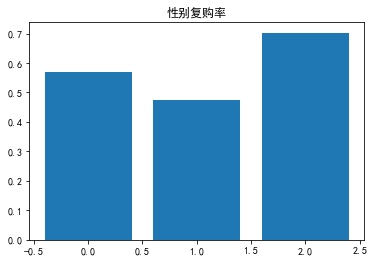

In [11]:
# 0女性，1男性，2表未知
# 性别标签丢失不碍事
print(user_rebuy.gender.isna().sum())
plt.bar(x = user_rebuy.gender.unique(), height=[user_rebuy.loc[user_rebuy['gender']==i,'if_rebuy'].mean() for i in user_rebuy.gender.unique()])
plt.title('性别复购率')

结论：中年用户即3、4、5、6，即30-50岁复购率相对高

2217


Text(0.5, 1.0, '年龄复购率')

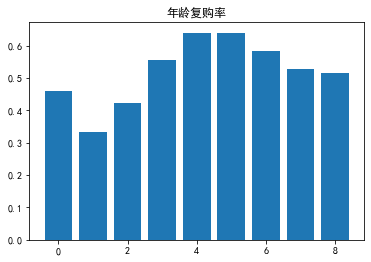

In [12]:
# 年龄标签丢失不碍事
print(user_rebuy.age_range.isna().sum())
plt.bar(x = user_rebuy.age_range.unique(), height=[user_rebuy.loc[user_rebuy['age_range']==i,'if_rebuy'].mean() for i in user_rebuy.age_range.unique()])
plt.title('年龄复购率')

最多复购的商品种类

In [13]:
cat_buy = pd.concat([buy.user_id,buy.cat_id,buy.groupby(['user_id', 'cat_id'])['cat_id'].transform('count').map(lambda x:0 if x<=1 else 1).rename('if_rebuy')],axis=1)
cat_rebuy = pd.DataFrame(buy.cat_id.drop_duplicates()).sort_values(by='cat_id').reset_index(drop=True)
cat_rebuy = cat_rebuy.merge(cat_buy[cat_buy['if_rebuy']==1].drop_duplicates().groupby('cat_id')['user_id'].aggregate('count'),how='left',on='cat_id').fillna(0)
cat_rebuy['rebuy_users'] = cat_rebuy['user_id'].astype(int)
cat_rebuy.drop('user_id',axis=1,inplace=True)
cat_rebuy

,cat_id,rebuy_users
0,1,5
1,2,144
2,3,0
3,4,17
4,5,109
...,...,...
1319,1665,3
1320,1666,15
1321,1668,32
1322,1670,1


Text(0.5, 1.0, '复购用户数前10的商品种类')

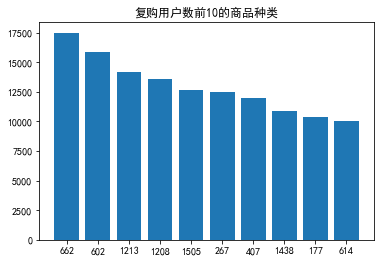

In [14]:
plt.bar(x=cat_rebuy.sort_values(by='rebuy_users',ascending=False).cat_id[:10].map(str),height=cat_rebuy.sort_values(by='rebuy_users',ascending=False).rebuy_users[:10])
plt.title('复购用户数前10的商品种类')

最多复购的店铺

In [15]:
merchant_rebuy = pd.DataFrame(buy.merchant_id.drop_duplicates()).sort_values(by='merchant_id').reset_index(drop=True)
merchant_rebuy = merchant_rebuy.merge(buy.loc[buy['if_rebuy']==1,['user_id','merchant_id','if_rebuy']].drop_duplicates().groupby('merchant_id')['user_id'].aggregate('count'),how='left',on='merchant_id').fillna(0)
merchant_rebuy['rebuy_users'] = merchant_rebuy['user_id'].astype(int)
merchant_rebuy.drop('user_id',axis=1,inplace=True)
merchant_rebuy

,merchant_id,rebuy_users
0,1,3584
1,2,14
2,3,2
3,4,35
4,5,15
...,...,...
4990,4991,5
4991,4992,314
4992,4993,79
4993,4994,16


Text(0.5, 1.0, '复购用户数前10的商店')

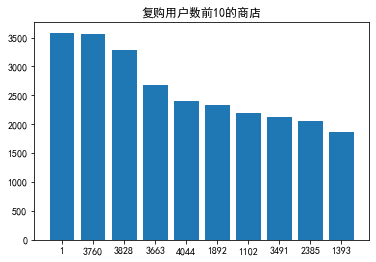

In [16]:
plt.bar(x=merchant_rebuy.sort_values(by='rebuy_users',ascending=False).merchant_id[:10].map(str),height=merchant_rebuy.sort_values(by='rebuy_users',ascending=False).rebuy_users[:10])
plt.title('复购用户数前10的商店')

年龄分布

(array([9.51310e+04, 2.40000e+01, 5.28710e+04, 1.11654e+05, 7.99910e+04,
        4.07770e+04, 3.54640e+04, 8.25800e+03]),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8.]),
 <BarContainer object of 8 artists>)

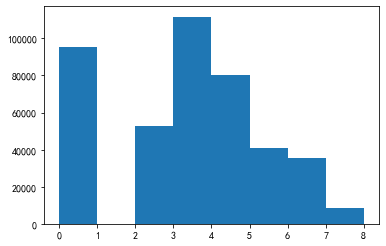

In [46]:
plt.hist(user_rebuy.age_range.tolist(),bins=user_rebuy.age_range.nunique()-1)

性别分布

(array([292074., 121670.,  10426.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <BarContainer object of 3 artists>)

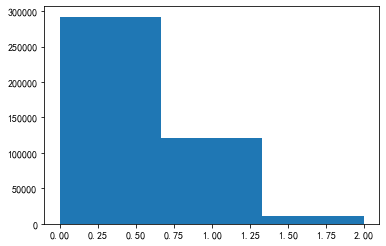

In [49]:
plt.hist(user_rebuy.gender.tolist(), bins=user_rebuy.gender.nunique())

# RFM模型

In [17]:
user_rebuy = user_rebuy.merge(buy[buy['time_stamp']!=1111].groupby('user_id')['time_stamp'].aggregate('max').rename('last_time'), how='left', on='user_id').fillna(0)
def time_freq(x):
    if (x.max()-x.min()):
        return len(x)/(x.max()-x.min())
    else:
        if len(x)>2:
            return len(x)
        else:
            return 0.
user_rebuy = user_rebuy.merge(buy.groupby('user_id')['time_stamp'].aggregate(time_freq).rename('time_freq'), how='left', on='user_id')
user_rebuy = user_rebuy.merge(buy.groupby('user_id')['user_id'].aggregate('count').rename('total_buy'), how='left', on='user_id')
user_rebuy

,user_id,if_rebuy,age_range,gender,last_time,time_freq,total_buy
0,1,0,3.0,1.0,1021.0,0.030000,3
1,2,1,3.0,0.0,1010.0,0.024742,12
2,3,0,3.0,0.0,819.0,0.005042,3
3,4,0,0.0,0.0,0.0,0.000000,1
4,5,1,5.0,0.0,1029.0,0.018613,11
...,...,...,...,...,...,...,...
424165,424166,1,2.0,1.0,1109.0,0.016750,10
424166,424167,0,3.0,1.0,1108.0,0.008591,5
424167,424168,0,5.0,0.0,1103.0,0.013333,4
424168,424169,1,0.0,0.0,1110.0,0.025000,15


In [18]:
print('median R:',user_rebuy.last_time.median())
print('median F:',user_rebuy.time_freq.median())
print('median M:',user_rebuy.total_buy.median())
print('new buyer num:',(user_rebuy['last_time']==0).sum())
print('mean F:',user_rebuy.time_freq.mean())
print('mean M:',user_rebuy.total_buy.mean())
print('max M:',user_rebuy.total_buy.max())

median R: 927.0
median F: 0.016494845360824743
median M: 5.0
new buyer num: 83412
mean F: 0.2964501916300758
mean M: 7.1052761864346845
max M: 822


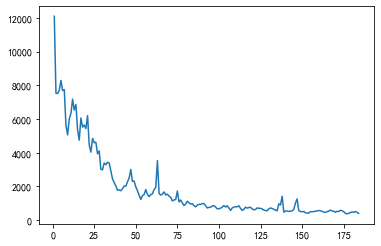

In [98]:
# 最后一次购买距双十一天数分布
def todate(x):
    if x!= 0:
        return '2021-'+str(int(x//100))+'-'+str(int(x-x//100*100))
    else:
        return np.nan
user_rebuy['last_time_date'] = user_rebuy['last_time'].map(todate)
user_rebuy['last_time_date'] = pd.to_datetime(user_rebuy['last_time_date'], format='%Y-%m-%d')
plt.plot(pd.Series((pd.to_datetime('2021-11-11',format='%Y-%m-%d')-user_rebuy.last_time_date).value_counts().index).dt.days.sort_values(),(pd.to_datetime('2021-11-11',format='%Y-%m-%d')-user_rebuy.last_time_date).value_counts().sort_index())

(array([5.9537e+04, 4.4670e+03, 1.4574e+04, 2.4198e+04, 2.1487e+04,
        3.3544e+04, 2.5282e+04, 2.3748e+04, 2.0299e+04, 1.7240e+04,
        2.1433e+04, 1.4910e+04, 1.3398e+04, 1.0067e+04, 9.5340e+03,
        9.8340e+03, 7.7880e+03, 6.6890e+03, 6.0910e+03, 4.9560e+03,
        4.2370e+03, 4.2530e+03, 3.5050e+03, 2.8580e+03, 3.1220e+03,
        2.1600e+03, 2.0200e+03, 1.7840e+03, 1.6250e+03, 1.5270e+03,
        1.4040e+03, 1.1160e+03, 9.9700e+02, 9.3900e+02, 7.8900e+02,
        7.3100e+02, 7.2300e+02, 6.4500e+02, 5.5300e+02, 4.0000e+02,
        4.0700e+02, 3.5800e+02, 3.9200e+02, 4.1100e+02, 2.5100e+02,
        3.0300e+02, 2.1000e+02, 2.4400e+02, 2.2200e+02, 1.5400e+02,
        2.0500e+02, 1.7500e+02, 1.6200e+02, 1.2100e+02, 1.3700e+02,
        1.2600e+02, 1.2900e+02, 8.6000e+01, 7.8000e+01, 8.8000e+01,
        7.6000e+01, 7.3000e+01, 6.3000e+01, 7.8000e+01, 4.1000e+01,
        5.9000e+01, 4.2000e+01, 6.3000e+01, 5.2000e+01, 4.8000e+01,
        4.2000e+01, 2.7000e+01, 3.7000e+01, 4.50

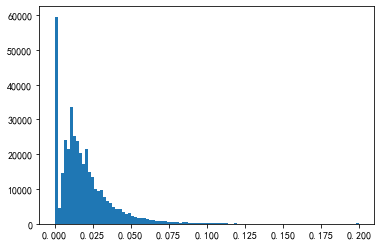

In [107]:
# 购买频数分布
plt.hist(user_rebuy.loc[user_rebuy['time_freq']<=0.2,'time_freq'],bins=100)

(array([3.8900e+04, 0.0000e+00, 5.2062e+04, 0.0000e+00, 5.1420e+04,
        0.0000e+00, 4.5803e+04, 0.0000e+00, 3.8416e+04, 0.0000e+00,
        3.2239e+04, 0.0000e+00, 2.6636e+04, 0.0000e+00, 2.1901e+04,
        0.0000e+00, 1.7997e+04, 0.0000e+00, 1.5055e+04, 0.0000e+00,
        1.2574e+04, 0.0000e+00, 1.0496e+04, 0.0000e+00, 8.6900e+03,
        0.0000e+00, 7.3540e+03, 0.0000e+00, 6.2170e+03, 0.0000e+00,
        5.1330e+03, 0.0000e+00, 4.5540e+03, 0.0000e+00, 3.7720e+03,
        0.0000e+00, 3.3410e+03, 0.0000e+00, 2.7680e+03, 0.0000e+00,
        2.3600e+03, 0.0000e+00, 2.1060e+03, 0.0000e+00, 1.7620e+03,
        0.0000e+00, 1.4970e+03, 0.0000e+00, 1.3050e+03, 0.0000e+00,
        0.0000e+00, 1.1550e+03, 0.0000e+00, 9.8200e+02, 0.0000e+00,
        9.0100e+02, 0.0000e+00, 7.6200e+02, 0.0000e+00, 6.4700e+02,
        0.0000e+00, 5.7800e+02, 0.0000e+00, 4.9200e+02, 0.0000e+00,
        4.3500e+02, 0.0000e+00, 3.9700e+02, 0.0000e+00, 3.5000e+02,
        0.0000e+00, 2.9000e+02, 0.0000e+00, 2.66

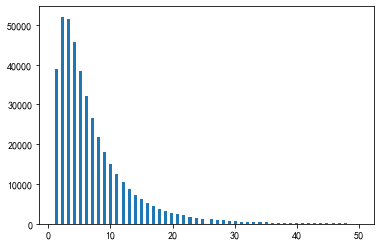

In [109]:
# 购买总数分布
plt.hist(user_rebuy.loc[user_rebuy['total_buy']<=50,'total_buy'],bins=100)

In [19]:
# 先凭经验分割
# 1010，0.05，9
user_rebuy.loc[(user_rebuy['last_time']>=1010)&(user_rebuy['time_freq']>=0.05)&(user_rebuy['total_buy']>=9),'type'] = '重要价值'
user_rebuy.loc[(user_rebuy['last_time']>=1010)&(user_rebuy['time_freq']<0.05)&(user_rebuy['total_buy']>=9),'type'] = '重要发展'
user_rebuy.loc[(user_rebuy['last_time']<1010)&(user_rebuy['time_freq']>=0.05)&(user_rebuy['total_buy']>=9),'type'] = '重要保持'
user_rebuy.loc[(user_rebuy['last_time']<1010)&(user_rebuy['time_freq']<0.05)&(user_rebuy['total_buy']>=9),'type'] = '重要挽留'
user_rebuy.loc[(user_rebuy['last_time']>=1010)&(user_rebuy['time_freq']>=0.05)&(user_rebuy['total_buy']<9),'type'] = '一般价值'
user_rebuy.loc[(user_rebuy['last_time']>=1010)&(user_rebuy['time_freq']<0.05)&(user_rebuy['total_buy']<9),'type'] = '一般发展'
user_rebuy.loc[(user_rebuy['last_time']<1010)&(user_rebuy['time_freq']>=0.05)&(user_rebuy['total_buy']<9),'type'] = '一般保持'
user_rebuy.loc[(user_rebuy['last_time']<1010)&(user_rebuy['last_time']!=0)&(user_rebuy['time_freq']<0.05)&(user_rebuy['total_buy']<9),'type'] = '一般挽留'
user_rebuy.loc[(user_rebuy['last_time']==0)&(user_rebuy['time_freq']<0.05)&(user_rebuy['total_buy']<9),'type'] = '新用户'
print('重要价值',user_rebuy[user_rebuy['type']=='重要价值'].shape[0],'占比',user_rebuy[user_rebuy['type']=='重要价值'].shape[0]/4241.7)
print('重要发展',user_rebuy[user_rebuy['type']=='重要发展'].shape[0],'占比',user_rebuy[user_rebuy['type']=='重要发展'].shape[0]/4241.7)
print('重要保持',user_rebuy[user_rebuy['type']=='重要保持'].shape[0],'占比',user_rebuy[user_rebuy['type']=='重要保持'].shape[0]/4241.7)
print('重要挽留',user_rebuy[user_rebuy['type']=='重要挽留'].shape[0],'占比',user_rebuy[user_rebuy['type']=='重要挽留'].shape[0]/4241.7)
print('一般价值',user_rebuy[user_rebuy['type']=='一般价值'].shape[0],'占比',user_rebuy[user_rebuy['type']=='一般价值'].shape[0]/4241.7)
print('一般发展',user_rebuy[user_rebuy['type']=='一般发展'].shape[0],'占比',user_rebuy[user_rebuy['type']=='一般发展'].shape[0]/4241.7)
print('一般保持',user_rebuy[user_rebuy['type']=='一般保持'].shape[0],'占比',user_rebuy[user_rebuy['type']=='一般保持'].shape[0]/4241.7)
print('一般挽留',user_rebuy[user_rebuy['type']=='一般挽留'].shape[0],'占比',user_rebuy[user_rebuy['type']=='一般挽留'].shape[0]/4241.7)
print('新用户',user_rebuy[user_rebuy['type']=='新用户'].shape[0],'占比',user_rebuy[user_rebuy['type']=='新用户'].shape[0]/4241.7)

重要价值 13076 占比 3.0827262654124525
重要发展 70883 占比 16.710988518754274
重要保持 2881 占比 0.6792088077893298
重要挽留 29953 占比 7.061555508404649
一般价值 17791 占比 4.194308885588326
一般发展 82661 占比 19.48770540113634
一般保持 23371 占比 5.509819176273664
一般挽留 124017 占比 29.23756984228022
新用户 59537 占比 14.036117594360752


Text(0.5, 1.0, '不同type用户复购率')

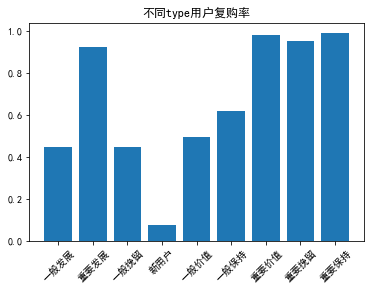

In [20]:
plt.bar(x = user_rebuy.type.unique(), height=[user_rebuy.loc[user_rebuy['type']==i,'if_rebuy'].mean() for i in user_rebuy.type.unique()])
plt.xticks(rotation=45)
plt.title('不同type用户复购率')

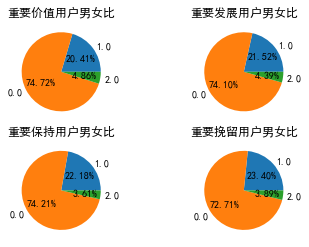

In [21]:
plt.subplot(2,2,1)
plt.pie(labels = user_rebuy.gender.unique(), x=[user_rebuy[(user_rebuy['gender']==i)&(user_rebuy['type']=='重要价值')].shape[0] for i in user_rebuy.gender.unique()],autopct='%.2f%%')
plt.title('重要价值用户男女比')
plt.subplot(2,2,2)
plt.pie(labels = user_rebuy.gender.unique(), x=[user_rebuy[(user_rebuy['gender']==i)&(user_rebuy['type']=='重要发展')].shape[0] for i in user_rebuy.gender.unique()],autopct='%.2f%%')
plt.title('重要发展用户男女比')
plt.subplot(2,2,3)
plt.pie(labels = user_rebuy.gender.unique(), x=[user_rebuy[(user_rebuy['gender']==i)&(user_rebuy['type']=='重要保持')].shape[0] for i in user_rebuy.gender.unique()],autopct='%.2f%%')
plt.title('重要保持用户男女比')
plt.subplot(2,2,4)
plt.pie(labels = user_rebuy.gender.unique(), x=[user_rebuy[(user_rebuy['gender']==i)&(user_rebuy['type']=='重要挽留')].shape[0] for i in user_rebuy.gender.unique()],autopct='%.2f%%')
plt.title('重要挽留用户男女比')
plt.show()

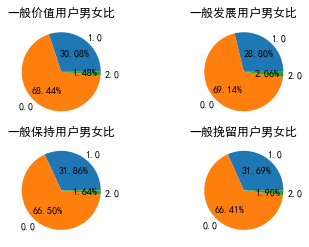

In [22]:
plt.subplot(2,2,1)
plt.pie(labels = user_rebuy.gender.unique(), x=[user_rebuy[(user_rebuy['gender']==i)&(user_rebuy['type']=='一般价值')].shape[0] for i in user_rebuy.gender.unique()],autopct='%.2f%%')
plt.title('一般价值用户男女比')
plt.subplot(2,2,2)
plt.pie(labels = user_rebuy.gender.unique(), x=[user_rebuy[(user_rebuy['gender']==i)&(user_rebuy['type']=='一般发展')].shape[0] for i in user_rebuy.gender.unique()],autopct='%.2f%%')
plt.title('一般发展用户男女比')
plt.subplot(2,2,3)
plt.pie(labels = user_rebuy.gender.unique(), x=[user_rebuy[(user_rebuy['gender']==i)&(user_rebuy['type']=='一般保持')].shape[0] for i in user_rebuy.gender.unique()],autopct='%.2f%%')
plt.title('一般保持用户男女比')
plt.subplot(2,2,4)
plt.pie(labels = user_rebuy.gender.unique(), x=[user_rebuy[(user_rebuy['gender']==i)&(user_rebuy['type']=='一般挽留')].shape[0] for i in user_rebuy.gender.unique()],autopct='%.2f%%')
plt.title('一般挽留用户男女比')
plt.show()

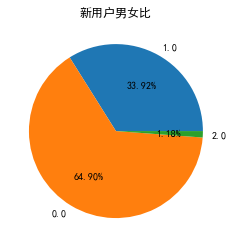

In [23]:
plt.pie(labels = user_rebuy.gender.unique(), x=[user_rebuy[(user_rebuy['gender']==i)&(user_rebuy['type']=='新用户')].shape[0] for i in user_rebuy.gender.unique()],autopct='%.2f%%')
plt.title('新用户男女比')
plt.show()

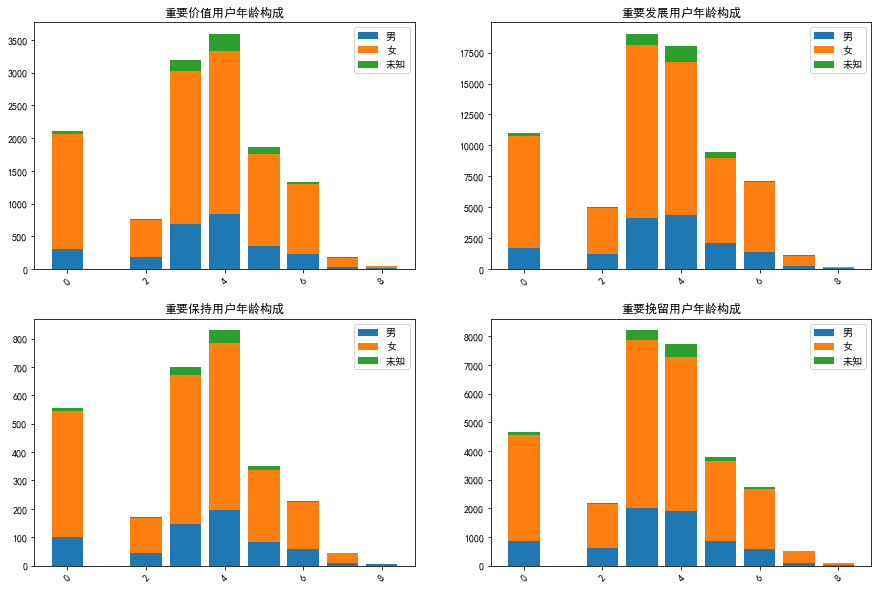

In [24]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.bar(x = user_rebuy.age_range.unique(), height=[user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='重要价值')&(user_rebuy['gender']==1.)].shape[0] for i in user_rebuy.age_range.unique()],label='男')
plt.bar(x = user_rebuy.age_range.unique(), height=[user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='重要价值')&(user_rebuy['gender']==0.)].shape[0] for i in user_rebuy.age_range.unique()],bottom=[user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='重要价值')&(user_rebuy['gender']==1.)].shape[0] for i in user_rebuy.age_range.unique()],label='女')
plt.bar(x = user_rebuy.age_range.unique(), height=[user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='重要价值')&(user_rebuy['gender']==2.)].shape[0] for i in user_rebuy.age_range.unique()],bottom=np.array([user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='重要价值')&(user_rebuy['gender']==0.)].shape[0] for i in user_rebuy.age_range.unique()])+np.array([user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='重要价值')&(user_rebuy['gender']==1.)].shape[0] for i in user_rebuy.age_range.unique()]),label='未知')
plt.xticks(rotation=45)
plt.title('重要价值用户年龄构成')
plt.legend()
plt.subplot(2,2,2)
plt.bar(x = user_rebuy.age_range.unique(), height=[user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='重要发展')&(user_rebuy['gender']==1.)].shape[0] for i in user_rebuy.age_range.unique()],label='男')
plt.bar(x = user_rebuy.age_range.unique(), height=[user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='重要发展')&(user_rebuy['gender']==0.)].shape[0] for i in user_rebuy.age_range.unique()],bottom=[user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='重要发展')&(user_rebuy['gender']==1.)].shape[0] for i in user_rebuy.age_range.unique()],label='女')
plt.bar(x = user_rebuy.age_range.unique(), height=[user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='重要发展')&(user_rebuy['gender']==2.)].shape[0] for i in user_rebuy.age_range.unique()],bottom=np.array([user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='重要发展')&(user_rebuy['gender']==0.)].shape[0] for i in user_rebuy.age_range.unique()])+np.array([user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='重要发展')&(user_rebuy['gender']==1.)].shape[0] for i in user_rebuy.age_range.unique()]),label='未知')
plt.xticks(rotation=45)
plt.title('重要发展用户年龄构成')
plt.legend()
plt.subplot(2,2,3)
plt.bar(x = user_rebuy.age_range.unique(), height=[user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='重要保持')&(user_rebuy['gender']==1.)].shape[0] for i in user_rebuy.age_range.unique()],label='男')
plt.bar(x = user_rebuy.age_range.unique(), height=[user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='重要保持')&(user_rebuy['gender']==0.)].shape[0] for i in user_rebuy.age_range.unique()],bottom=[user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='重要保持')&(user_rebuy['gender']==1.)].shape[0] for i in user_rebuy.age_range.unique()],label='女')
plt.bar(x = user_rebuy.age_range.unique(), height=[user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='重要保持')&(user_rebuy['gender']==2.)].shape[0] for i in user_rebuy.age_range.unique()],bottom=np.array([user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='重要保持')&(user_rebuy['gender']==0.)].shape[0] for i in user_rebuy.age_range.unique()])+np.array([user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='重要保持')&(user_rebuy['gender']==1.)].shape[0] for i in user_rebuy.age_range.unique()]),label='未知')
plt.xticks(rotation=45)
plt.title('重要保持用户年龄构成')
plt.legend()
plt.subplot(2,2,4)
plt.bar(x = user_rebuy.age_range.unique(), height=[user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='重要挽留')&(user_rebuy['gender']==1.)].shape[0] for i in user_rebuy.age_range.unique()],label='男')
plt.bar(x = user_rebuy.age_range.unique(), height=[user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='重要挽留')&(user_rebuy['gender']==0.)].shape[0] for i in user_rebuy.age_range.unique()],bottom=[user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='重要挽留')&(user_rebuy['gender']==1.)].shape[0] for i in user_rebuy.age_range.unique()],label='女')
plt.bar(x = user_rebuy.age_range.unique(), height=[user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='重要挽留')&(user_rebuy['gender']==2.)].shape[0] for i in user_rebuy.age_range.unique()],bottom=np.array([user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='重要挽留')&(user_rebuy['gender']==0.)].shape[0] for i in user_rebuy.age_range.unique()])+np.array([user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='重要挽留')&(user_rebuy['gender']==1.)].shape[0] for i in user_rebuy.age_range.unique()]),label='未知')
plt.xticks(rotation=45)
plt.title('重要挽留用户年龄构成')
plt.legend()

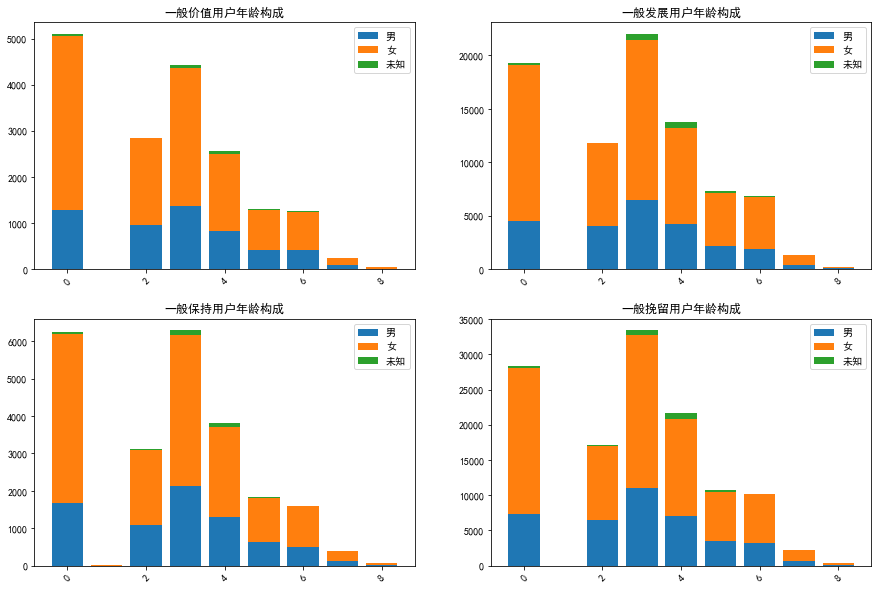

In [25]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.bar(x = user_rebuy.age_range.unique(), height=[user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='一般价值')&(user_rebuy['gender']==1.)].shape[0] for i in user_rebuy.age_range.unique()],label='男')
plt.bar(x = user_rebuy.age_range.unique(), height=[user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='一般价值')&(user_rebuy['gender']==0.)].shape[0] for i in user_rebuy.age_range.unique()],bottom=[user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='一般价值')&(user_rebuy['gender']==1.)].shape[0] for i in user_rebuy.age_range.unique()],label='女')
plt.bar(x = user_rebuy.age_range.unique(), height=[user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='一般价值')&(user_rebuy['gender']==2.)].shape[0] for i in user_rebuy.age_range.unique()],bottom=np.array([user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='一般价值')&(user_rebuy['gender']==0.)].shape[0] for i in user_rebuy.age_range.unique()])+np.array([user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='一般价值')&(user_rebuy['gender']==1.)].shape[0] for i in user_rebuy.age_range.unique()]),label='未知')
plt.xticks(rotation=45)
plt.title('一般价值用户年龄构成')
plt.legend()
plt.subplot(2,2,2)
plt.bar(x = user_rebuy.age_range.unique(), height=[user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='一般发展')&(user_rebuy['gender']==1.)].shape[0] for i in user_rebuy.age_range.unique()],label='男')
plt.bar(x = user_rebuy.age_range.unique(), height=[user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='一般发展')&(user_rebuy['gender']==0.)].shape[0] for i in user_rebuy.age_range.unique()],bottom=[user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='一般发展')&(user_rebuy['gender']==1.)].shape[0] for i in user_rebuy.age_range.unique()],label='女')
plt.bar(x = user_rebuy.age_range.unique(), height=[user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='一般发展')&(user_rebuy['gender']==2.)].shape[0] for i in user_rebuy.age_range.unique()],bottom=np.array([user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='一般发展')&(user_rebuy['gender']==0.)].shape[0] for i in user_rebuy.age_range.unique()])+np.array([user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='一般发展')&(user_rebuy['gender']==1.)].shape[0] for i in user_rebuy.age_range.unique()]),label='未知')
plt.xticks(rotation=45)
plt.title('一般发展用户年龄构成')
plt.legend()
plt.subplot(2,2,3)
plt.bar(x = user_rebuy.age_range.unique(), height=[user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='一般保持')&(user_rebuy['gender']==1.)].shape[0] for i in user_rebuy.age_range.unique()],label='男')
plt.bar(x = user_rebuy.age_range.unique(), height=[user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='一般保持')&(user_rebuy['gender']==0.)].shape[0] for i in user_rebuy.age_range.unique()],bottom=[user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='一般保持')&(user_rebuy['gender']==1.)].shape[0] for i in user_rebuy.age_range.unique()],label='女')
plt.bar(x = user_rebuy.age_range.unique(), height=[user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='一般保持')&(user_rebuy['gender']==2.)].shape[0] for i in user_rebuy.age_range.unique()],bottom=np.array([user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='一般保持')&(user_rebuy['gender']==0.)].shape[0] for i in user_rebuy.age_range.unique()])+np.array([user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='一般保持')&(user_rebuy['gender']==1.)].shape[0] for i in user_rebuy.age_range.unique()]),label='未知')
plt.xticks(rotation=45)
plt.title('一般保持用户年龄构成')
plt.legend()
plt.subplot(2,2,4)
plt.bar(x = user_rebuy.age_range.unique(), height=[user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='一般挽留')&(user_rebuy['gender']==1.)].shape[0] for i in user_rebuy.age_range.unique()],label='男')
plt.bar(x = user_rebuy.age_range.unique(), height=[user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='一般挽留')&(user_rebuy['gender']==0.)].shape[0] for i in user_rebuy.age_range.unique()],bottom=[user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='一般挽留')&(user_rebuy['gender']==1.)].shape[0] for i in user_rebuy.age_range.unique()],label='女')
plt.bar(x = user_rebuy.age_range.unique(), height=[user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='一般挽留')&(user_rebuy['gender']==2.)].shape[0] for i in user_rebuy.age_range.unique()],bottom=np.array([user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='一般挽留')&(user_rebuy['gender']==0.)].shape[0] for i in user_rebuy.age_range.unique()])+np.array([user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='一般挽留')&(user_rebuy['gender']==1.)].shape[0] for i in user_rebuy.age_range.unique()]),label='未知')
plt.xticks(rotation=45)
plt.title('一般挽留用户年龄构成')
plt.legend()

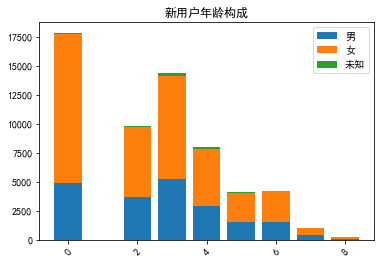

In [26]:
plt.bar(x = user_rebuy.age_range.unique(), height=[user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='新用户')&(user_rebuy['gender']==1.)].shape[0] for i in user_rebuy.age_range.unique()],label='男')
plt.bar(x = user_rebuy.age_range.unique(), height=[user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='新用户')&(user_rebuy['gender']==0.)].shape[0] for i in user_rebuy.age_range.unique()],bottom=[user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='新用户')&(user_rebuy['gender']==1.)].shape[0] for i in user_rebuy.age_range.unique()],label='女')
plt.bar(x = user_rebuy.age_range.unique(), height=[user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='新用户')&(user_rebuy['gender']==2.)].shape[0] for i in user_rebuy.age_range.unique()],bottom=np.array([user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='新用户')&(user_rebuy['gender']==0.)].shape[0] for i in user_rebuy.age_range.unique()])+np.array([user_rebuy[(user_rebuy['age_range']==i)&(user_rebuy['type']=='新用户')&(user_rebuy['gender']==1.)].shape[0] for i in user_rebuy.age_range.unique()]),label='未知')
plt.xticks(rotation=45)
plt.title('新用户年龄构成')
plt.legend()

复购用户与未复购用户

([<matplotlib.patches.Wedge at 0x2729e62fb50>,
 [Text(-0.14504277912625696, 1.0903956127128043, '复购'),
  Text(0.14504288121646153, -1.0903955991329144, '未复购')],
 [Text(-0.07911424315977651, 0.5947612432978931, '54.21%'),
  Text(0.07911429884534264, -0.5947612358906805, '45.79%')])

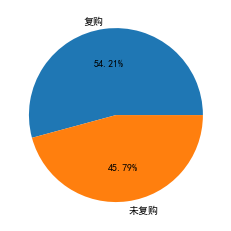

In [27]:
plt.pie(labels=['复购','未复购'],x=[user_rebuy[user_rebuy['if_rebuy']==1].shape[0],user_rebuy[user_rebuy['if_rebuy']==0].shape[0]],autopct='%.2f%%')

复购商店数与用户各特征关系

In [28]:
# 添加一列复购商店数
user_rebuy = user_rebuy.merge(buy.loc[buy['if_rebuy']==1,['user_id','merchant_id']].drop_duplicates().groupby('user_id')['merchant_id'].aggregate('count'),how='left',on='user_id').rename(columns={'merchant_id':'rebuy_mer_cnt'}).fillna(0.)

(-1.0, 10.0)

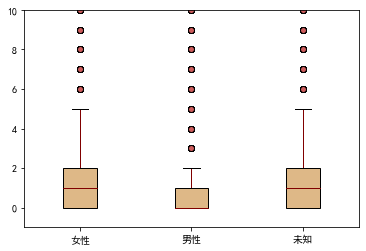

In [29]:
plt.boxplot([user_rebuy.loc[user_rebuy['gender']==0.,'rebuy_mer_cnt'].tolist(),
             user_rebuy.loc[user_rebuy['gender']==1.,'rebuy_mer_cnt'].tolist(),
             user_rebuy.loc[user_rebuy['gender']==2.,'rebuy_mer_cnt'].tolist()],
            labels=['女性','男性','未知'],
            flierprops={'markerfacecolor':'#CD5C5C'},
            whiskerprops={'color':'#800000'},
            patch_artist=True,
            boxprops={'facecolor':'#DEB887'},
            medianprops={'color':'#800000'})
plt.ylim(-1,10)

<BarContainer object of 3 artists>

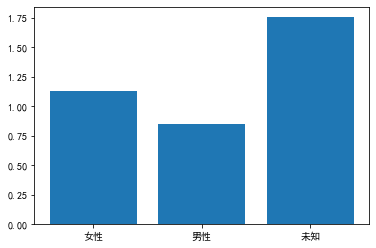

In [30]:
# 男性复购平均连一家都没到
plt.bar(x=['女性','男性','未知'],height=[user_rebuy.loc[user_rebuy['gender']==0.,'rebuy_mer_cnt'].mean(),user_rebuy.loc[user_rebuy['gender']==1.,'rebuy_mer_cnt'].mean(),user_rebuy.loc[user_rebuy['gender']==2.,'rebuy_mer_cnt'].mean()])

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

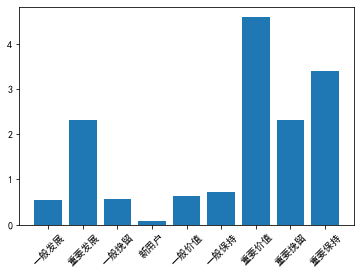

In [31]:
plt.bar(x=user_rebuy.type.drop_duplicates(),height=[user_rebuy.loc[user_rebuy['type']==i,'rebuy_mer_cnt'].mean() for i in user_rebuy.type.drop_duplicates()])
plt.xticks(rotation=45)

In [37]:
# 复购店铺数与购买商品种类数
user_rebuy = user_rebuy.merge(buy[['user_id','cat_id']].drop_duplicates().groupby('user_id')['cat_id'].agg('count').rename('cat_buy_cnt'), how='left',on='user_id')

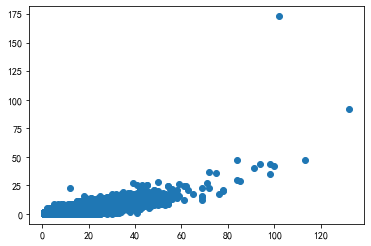

In [39]:
plt.scatter(user_rebuy.cat_buy_cnt.tolist(), user_rebuy.rebuy_mer_cnt.tolist())

In [58]:
# 复购店铺数与浏览商品种类数
user_rebuy = user_rebuy.merge(user_log.loc[user_log['action_type']==0,['user_id','cat_id']].drop_duplicates().groupby('user_id')['cat_id'].agg('count').rename('cat_view_cnt'), how='left',on='user_id')

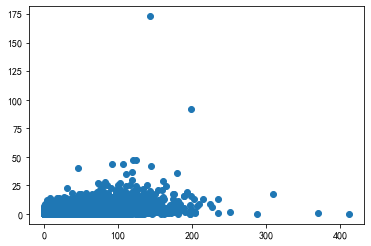

In [59]:
plt.scatter(user_rebuy.cat_view_cnt.tolist(), user_rebuy.rebuy_mer_cnt.tolist())

In [62]:
# 复购店铺数与加购物车数
user_rebuy = user_rebuy.merge(user_log.loc[user_log['action_type']==1,['user_id','action_type']].groupby('user_id')['action_type'].agg('count').rename('total_car'), how='left',on='user_id')

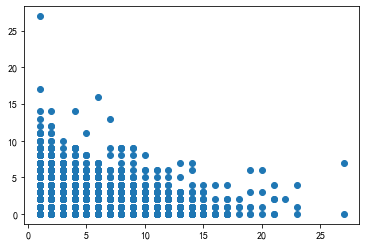

In [64]:
plt.scatter(user_rebuy.total_car.tolist(), user_rebuy.rebuy_mer_cnt.tolist())

0


Text(0.5, 1.0, '年龄购买数')

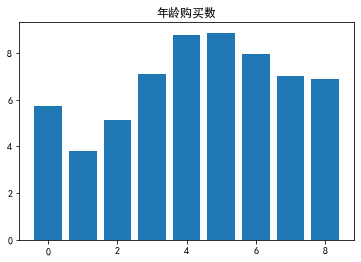

In [41]:
# 年龄购买数
print(user_rebuy.age_range.isna().sum())
plt.bar(x = user_rebuy.age_range.unique(), height=[user_rebuy.loc[user_rebuy['age_range']==i,'total_buy'].mean() for i in user_rebuy.age_range.unique()])
plt.title('年龄购买数')

0


Text(0.5, 1.0, '年龄双11购买数')

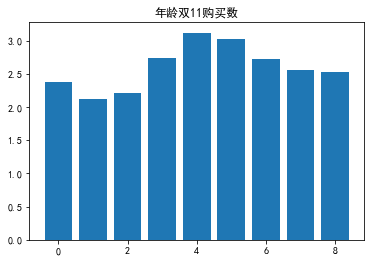

In [42]:
# 年龄双11购买数
print(user_rebuy.age_range.isna().sum())
plt.bar(x = user_rebuy.age_range.unique(), height=[user_rebuy.loc[user_rebuy['age_range']==i,'1111buy'].mean() for i in user_rebuy.age_range.unique()])
plt.title('年龄双11购买数')

In [55]:
user_rebuy[user_rebuy['type']=='新用户'].total_buy.mean()

1.346624787946991

不同用户群体双11购买数

In [32]:
user_rebuy = user_rebuy.merge(buy[buy['time_stamp']==1111].groupby('user_id')['user_id'].aggregate('count').rename('1111buy'), how='left', on='user_id')

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

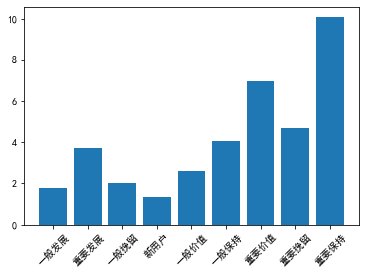

In [33]:
plt.bar(x=user_rebuy.type.drop_duplicates(),height=[user_rebuy.loc[user_rebuy['type']==i,'1111buy'].mean() for i in user_rebuy.type.drop_duplicates()])
plt.xticks(rotation=45)

不同用户群体总购买数

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

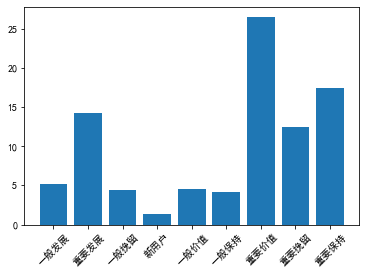

In [110]:
plt.bar(x=user_rebuy.type.drop_duplicates(),height=[user_rebuy.loc[user_rebuy['type']==i,'total_buy'].mean() for i in user_rebuy.type.drop_duplicates()])
plt.xticks(rotation=45)

# 总结

女性多、25-29多，30-34其次，25-39都是购买力较高人群

RFM模型如何分群，R值F值M值如何确定

RFM各群的年龄构成，性别构成，可以看出女性、年龄在30-34的是最核心用户

各群用户的双十一购买量可以看出，这样的大型打折活动对挽留客户较为有效。此外保持用户双十一购买是最多的

大部分特征都与复购率复购商店数呈正相关，但是有一个购物车数是负相关。这很有意思的说明了爱加购物车但最终没有购买的用户他们可能是偏向精打细算、货比三家的，大概率不会一直在某个店铺中购买，也即复购表现会比较低。想要吸引或挽留这批用户，用一些小优惠可能很有效。

（属于暂无经验的单纯的自身见解，不一定对）